## Classificador Ecografia

Importem les llibreries necessàries 

In [2]:
from pathlib import Path
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Carreguem les imatges

In [3]:
path = Path(".../mamaeco")
path.ls()

(#3) [Path('/kaggle/input/mamaeco/CYST'),Path('/kaggle/input/mamaeco/IDC'),Path('/kaggle/input/mamaeco/FA')]


Creem el DataBlock que ens ajudarà a carregar les imatges, i preparar-les. 
Especifiquem que treballarem amb imatges i etiquetes, obtindrem les imatges, les dividirem aleatòriament de manera que tindrem un 80% per entrenar i un 20% per validar, obtindrem les etiquetes i, per últim, redimensionarem les imatges. 

In [6]:
img = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

Abans de crear el DataLoader, realitzarem un augment de dades, agafant les dades que tenim i els hi apliquem transformacions, com rotacions, translacions, ...
Al DataLoader especificarem la direcció de la carpeta on hi ha les imatges i el batch size, utilitzant el DataBlock que hem creat. 

In [ ]:
img = img.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = img.dataloaders(path, bs=16)

Mostrem les imatges que hem carregat al DataLoader

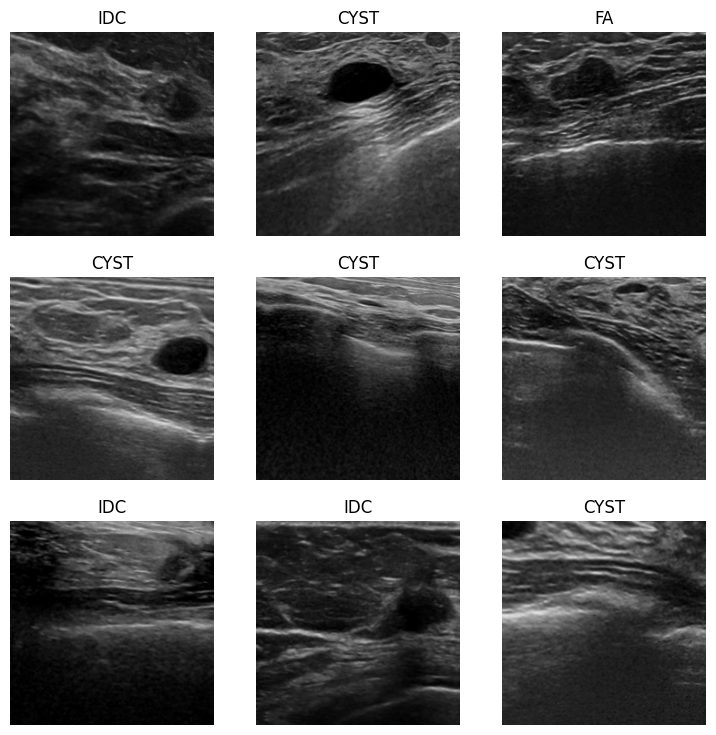

In [8]:
dls.show_batch()

Amb class_weight definirem una llista que conté els pesos assignats a cada classe, com en aquest cas tenim més imatges de CYST que de les altres, li assignarem un pes de 1, mentre que a FA i IDC els hi assignarem un pes de 2. 
Creem el Learner utilitzant la funció vision_learner on li passarem el DataLoader, l’arquitectura preentrenada alexnet, una mètrica d’avaluacio del model, en aquest cas la precisió i la funció de pèrdua, loss function, on utilitzarem la Cross Entropy Loss passant-li els pesos definits anteriorment.

La funció de pèrdua el que fa és quantificar l’error entre les prediccions i les etiquetes, i ajusten els paràmetres del model durant l’entrenament de manera que la pèrdua es minimitzi. 

In [9]:
class_weights = [1.0, 2.0, 2.0]
learn = vision_learner(dls, alexnet, metrics=accuracy, loss_func=CrossEntropyLossFlat(weight=torch.FloatTensor(class_weights)))
#lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.5MB/s]


Busquem el valor òptim de learning rate, aquell que ens permeti un entrenament més eficient. 

SuggestedLRs(valley=0.0063095735386013985)

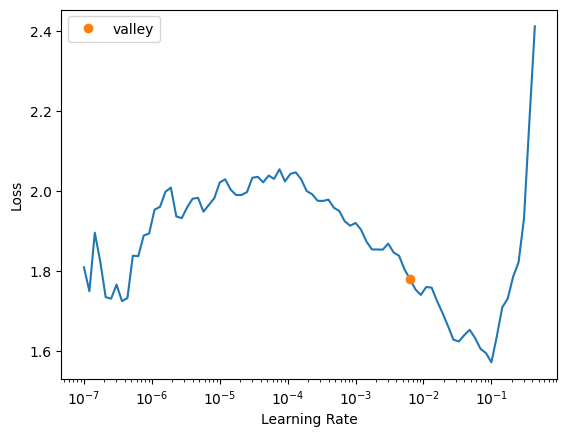

In [10]:
learn.lr_find()

Entrenem el model, especificant el nombre d'epochs i el learning rate

In [11]:
learn.fit_one_cycle(12, 10e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.098581,1.134514,0.727273,00:01
1,2.598580,5.166058,0.590909,00:01
2,3.091824,7.729739,0.681818,00:01
3,3.412049,4.461382,0.727273,00:01
4,3.858253,5.065224,0.590909,00:01
5,4.414989,5.866646,0.727273,00:01
6,4.422802,5.405511,0.636364,00:01
7,4.275094,4.073279,0.636364,00:01
8,4.302150,4.260097,0.727273,00:01
9,4.163328,3.705071,0.772727,00:01


Mostrem la matriu de confusió resultant. Aquesta matriu mostrarà com classifica les dades de validació.

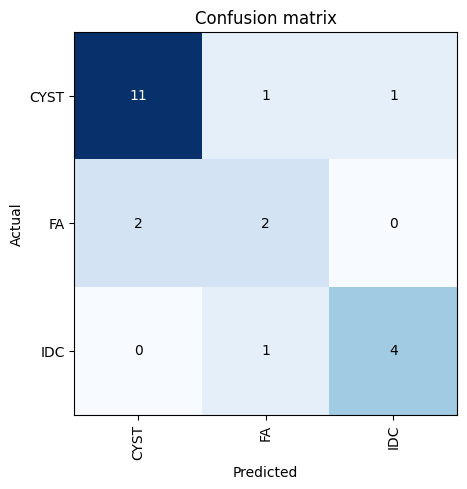

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Mostrem visualment la classificació que realitza el nostre model

In [ ]:
learn.show_results()

Exportem el model per a poder utilitzar-lo més endavant 

In [13]:
learn.export('model.pkl')